# **Individual Assignment: Liquor Sales**

## Data Processing

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import folium
from matplotlib.ticker import FuncFormatter
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load the dataset
liquor_df = pd.read_csv(
    r"C:\Users\PC\Desktop\big-data\data\liqoir_sales\Iowa_Liquor_Sales.csv",
    dtype={"Zip Code": str},
    low_memory=False
)

In [3]:
# Drop redundant columns
cols_to_drop = ['County Number', 'Volume Sold (Gallons)', 'Invoice/Item Number', 'Address', 'Zip Code',  'Vendor Name',  'Item Description',
                'Store Number', 'Vendor Number', 'Item Number', 'Pack', 'Volume Sold (Liters)', 'Category']
liquor_df.drop(columns=cols_to_drop, inplace=True)

In [4]:
# Ensure date column is datetime
liquor_df['Date'] = pd.to_datetime(liquor_df['Date'], errors='coerce')

# Normalize string casing for consistent grouping
liquor_df['Store Name'] = liquor_df['Store Name'].str.title().str.strip()
liquor_df['City'] = liquor_df['City'].str.title().str.strip()
liquor_df['County'] = liquor_df['County'].str.upper().str.strip()
liquor_df['Category Name'] = liquor_df['Category Name'].str.title().str.strip()

# Convert price-related columns to float
liquor_df['State Bottle Cost'] = liquor_df['State Bottle Cost'].replace('[\$,]', '', regex=True).astype(float)
liquor_df['State Bottle Retail'] = liquor_df['State Bottle Retail'].replace('[\$,]', '', regex=True).astype(float)
liquor_df['Sale (Dollars)'] = liquor_df['Sale (Dollars)'].replace('[\$,]', '', regex=True).astype(float)

In [5]:
# Print all unique counties from the 'County' column
unique_counties = liquor_df["County"].dropna().unique()
print(sorted(unique_counties))

['ADAIR', 'ADAMS', 'ALLAMAKEE', 'APPANOOSE', 'AUDUBON', 'BENTON', 'BLACK HAWK', 'BOONE', 'BREMER', 'BUCHANAN', 'BUENA VIST', 'BUENA VISTA', 'BUTLER', 'CALHOUN', 'CARROLL', 'CASS', 'CEDAR', 'CERRO GORD', 'CERRO GORDO', 'CHEROKEE', 'CHICKASAW', 'CLARKE', 'CLAY', 'CLAYTON', 'CLINTON', 'CRAWFORD', 'DALLAS', 'DAVIS', 'DECATUR', 'DELAWARE', 'DES MOINES', 'DICKINSON', 'DUBUQUE', 'EMMET', 'FAYETTE', 'FLOYD', 'FRANKLIN', 'FREMONT', 'GREENE', 'GRUNDY', 'GUTHRIE', 'HAMILTON', 'HANCOCK', 'HARDIN', 'HARRISON', 'HENRY', 'HOWARD', 'HUMBOLDT', 'IDA', 'IOWA', 'JACKSON', 'JASPER', 'JEFFERSON', 'JOHNSON', 'JONES', 'KEOKUK', 'KOSSUTH', 'LEE', 'LINN', 'LOUISA', 'LUCAS', 'LYON', 'MADISON', 'MAHASKA', 'MARION', 'MARSHALL', 'MILLS', 'MITCHELL', 'MONONA', 'MONROE', 'MONTGOMERY', 'MUSCATINE', "O'BRIEN", 'OBRIEN', 'OSCEOLA', 'PAGE', 'PALO ALTO', 'PLYMOUTH', 'POCAHONTAS', 'POLK', 'POTTAWATTA', 'POTTAWATTAMIE', 'POWESHIEK', 'RINGGOLD', 'SAC', 'SCOTT', 'SHELBY', 'SIOUX', 'STORY', 'TAMA', 'TAYLOR', 'UNION', 'VAN BUR

In [ ]:
# Inspect the data types
liquor_df.dtypes

Date                   datetime64[ns]
Store Name                     object
City                           object
Store Location                 object
County                         object
Category Name                  object
Bottle Volume (ml)              int64
State Bottle Cost             float64
State Bottle Retail           float64
Bottles Sold                    int64
Sale (Dollars)                float64
dtype: object

In [7]:
liquor_df

,Date,Store Name,City,Store Location,County,Category Name,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)
0,2015-11-20,Keokuk Spirits,Keokuk,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",LEE,NaN,750,18.09,27.14,6,162.84
1,2015-11-21,Ding'S Honk And Holler,Clarinda,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",PAGE,NaN,750,18.09,27.14,12,325.68
2,2015-11-16,Quicker Liquor Store,Fort Madison,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",LEE,NaN,150,6.40,9.60,2,19.20
3,2015-11-04,Hy-Vee Food Store #2 / Iowa City,Iowa City,812 S 1ST AVE\nIOWA CITY 52240\n,JOHNSON,NaN,1750,35.55,53.34,3,160.02
4,2015-11-17,Twin Town Liquor,Toledo,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",TAMA,NaN,150,6.40,9.60,2,19.20
...,...,...,...,...,...,...,...,...,...,...,...
12591072,2017-10-31,Stammer Liquor Corp,Sheldon,"615 2nd Ave\nSheldon 51201\n(43.184614, -95.85...",OBRIEN,Cocktails /Rtd,800,8.00,12.00,3,12.00
12591073,2017-10-31,Stammer Liquor Corp,Sheldon,"615 2nd Ave\nSheldon 51201\n(43.184614, -95.85...",OBRIEN,Straight Bourbon Whiskies,750,27.48,41.22,2,41.22
12591074,2017-10-31,Stammer Liquor Corp,Sheldon,"615 2nd Ave\nSheldon 51201\n(43.184614, -95.85...",OBRIEN,Bottled In Bond Bourbon,750,24.98,37.47,2,37.47
12591075,2017-10-31,Stammer Liquor Corp,Sheldon,"615 2nd Ave\nSheldon 51201\n(43.184614, -95.85...",OBRIEN,Straight Bourbon Whiskies,750,22.49,33.74,2,33.74


In [8]:
# Drop NULLs in County column
before = len(liquor_df)
liquor_df = liquor_df.dropna(subset=['County'])
after = len(liquor_df)
print(f"Rows dropped: {before - after}")

# Fix known misspellings and duplicates
county_corrections = {
    'BUENA VIST': 'BUENA VISTA',
    'CERRO GORD': 'CERRO GORDO',
    'OBRIEN': "O'BRIEN",
    'POTTAWATTA': 'POTTAWATTAMIE'
}
liquor_df['County'] = liquor_df['County'].replace(county_corrections)

# Check unique counties count
unique_counties = sorted(liquor_df['County'].dropna().unique())
print(f"Unique counties: {len(unique_counties)}")

Rows dropped: 79178


C:\Users\PC\AppData\Local\Temp\ipykernel_16656\2018479152.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liquor_df['County'] = liquor_df['County'].replace(county_corrections)


Unique counties: 99


In [9]:
# Inspect the dataset

# 1. Date range
date_min = liquor_df['Date'].min()
date_max = liquor_df['Date'].max()
print("Date range:", date_min.date(), "to", date_max.date())

# 2. Unique counties
counties = sorted(liquor_df['County'].dropna().unique())
print("Number of counties:", len(counties))
print("Example counties:", counties[:10])

# 3. Unique cities
cities = sorted(liquor_df['City'].dropna().unique())
print("Number of cities:", len(cities))
print("Example cities:", cities[:10])

# 4. Unique Bottle Sizes
bottle_sizes = sorted(liquor_df['Bottle Volume (ml)'].dropna().unique())
print("Unique bottle sizes (ml):", len(bottle_sizes))
print("Example bottle sizes:", bottle_sizes[:12])

# 5. Unique Stores
stores = sorted(liquor_df['Store Name'].dropna().unique())
print("Number of unique stores:", len(stores))
print("Example stores:", stores[:5])

Date range: 2012-01-03 to 2017-10-31
Number of counties: 99
Example counties: ['ADAIR', 'ADAMS', 'ALLAMAKEE', 'APPANOOSE', 'AUDUBON', 'BENTON', 'BLACK HAWK', 'BOONE', 'BREMER', 'BUCHANAN']
Number of cities: 416
Example cities: ['Ackley', 'Adair', 'Adel', 'Afton', 'Akron', 'Albert City', 'Albia', 'Albion', 'Alburnett', 'Alden']
Unique bottle sizes (ml): 49
Example bottle sizes: [np.int64(0), np.int64(12), np.int64(15), np.int64(50), np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(301), np.int64(375), np.int64(400)]
Number of unique stores: 1932
Example stores: ['"Double ""D"" Liquor Store"', '1St Stop Beverage Shop', "218 Fuel Express & Chubby'S Liquor", '3-Oaks Distillery, Llc', '3Rd St Convenience']


In [10]:
# Count entries with very large bottle sizes
above_1750 = liquor_df[liquor_df['Bottle Volume (ml)'] > 1750]
above_4500 = liquor_df[liquor_df['Bottle Volume (ml)'] > 4500]

print("Number of rows with bottle size > 1750ml:", len(above_1750))
print("Number of rows with bottle size > 4500ml:", len(above_4500))

Number of rows with bottle size > 1750ml: 65432
Number of rows with bottle size > 4500ml: 1141


In [ ]:
# Check the distributions of bottle sizes
print("Bottle size distribution (count of rows per size):")
print(liquor_df['Bottle Volume (ml)'].value_counts().sort_index())

Bottle size distribution (count of rows per size):
Bottle Volume (ml)
0              14
12              1
15              1
50           3898
100         38775
150           590
200        436861
250           709
300         61201
301           130
375       1214909
400           999
500        519861
502           349
600        139975
603           187
750       5686916
800         13653
850          1234
900           708
950           424
1000      1775101
1125          302
1200        13831
1500          112
1508            3
1750      2535723
1800           29
1850          757
1950          516
2000           23
2250          143
2400         4595
2550           42
3000        57652
3500          299
3600          161
3900           26
4500           48
4800          476
6000          599
7580            1
9000            3
31500          24
140000          8
180000          3
189000          2
225000          1
378000         24
Name: count, dtype: int64


In [12]:
# Filter out abnormal bottle sizes
before = len(liquor_df)
liquor_df = liquor_df[
    (liquor_df['Bottle Volume (ml)'] >= 50) &
    (liquor_df['Bottle Volume (ml)'] <= 1750)
]
after = len(liquor_df)
print(f"Rows dropped: {before - after}")

Rows dropped: 65448


In [ ]:
# Define final merge mapping
merge_map = {
    301: 300,
    502: 500,
    603: 600,
    950: 1000,
    1125: 1200,
    850: 800,
    400: 375 
}

# Apply merging
liquor_df.loc[:, 'Bottle Volume (ml)'] = liquor_df['Bottle Volume (ml)'].replace(merge_map)

# Explicitly drop unwanted sizes
explicit_drops = {900, 1500, 1508, 150, 250}
liquor_df = liquor_df[~liquor_df['Bottle Volume (ml)'].isin(explicit_drops)]

# Drop rare sizes (<500 rows), unless preserved
preserved_sizes = {50, 100, 200, 300, 375, 500, 600, 750, 800, 1000, 1200, 1750}
size_counts = liquor_df['Bottle Volume (ml)'].value_counts()
to_drop = [size for size in size_counts.index if size_counts[size] < 500 and size not in preserved_sizes]
liquor_df = liquor_df[~liquor_df['Bottle Volume (ml)'].isin(to_drop)]

print("Cleaned bottle size distribution:")
print(liquor_df['Bottle Volume (ml)'].value_counts().sort_index())

Cleaned bottle size distribution:
Bottle Volume (ml)
50         3898
100       38775
200      436861
300       61331
375     1215908
500      520210
600      140162
750     5686916
800       14887
1000    1775525
1200      14133
1750    2535723
Name: count, dtype: int64


In [14]:
# Final bottle sizes after cleaning
final_sizes = sorted(liquor_df['Bottle Volume (ml)'].unique())

# Thresholds for minimum acceptable prices
thresholds = {
    50:    0.99,
    100:   1.10,
    200:   1.85,
    375:   3.10,  
    500:   5.00,
    600:   6.00,
    750:   6.80,
    800:   6.80,
    1000:  7.00,
    1200:  8.00, 
    1750: 10.50
}

# Check low price rows and print percentages
print("Suspicious low-price checks (adjusted thresholds):")

for size in final_sizes:
    if size not in thresholds:
        continue
    min_price = thresholds[size]
    subset = liquor_df[liquor_df['Bottle Volume (ml)'] == size]
    low = subset[subset['State Bottle Retail'] < min_price]
    if not low.empty:
        percent = 100 * len(low) / len(subset)
        print(f"\n❗ {size} ml bottles (< ${min_price:.2f}): {len(low)} rows "
              f"({percent:.1f}% of {len(subset)} total)")
        print(low['Category Name'].value_counts().head(5))


Suspicious low-price checks (adjusted thresholds):

❗ 50 ml bottles (< $0.99): 5 rows (0.1% of 3898 total)
Category Name
Flavored Rum               2
American Grape Brandies    1
Apple Schnapps             1
Watermelon Schnapps        1
Name: count, dtype: int64

❗ 200 ml bottles (< $1.85): 60872 rows (13.9% of 436861 total)
Category Name
Vodka 80 Proof       33894
Blended Whiskies     10299
American Vodkas       6651
American Vodka        4671
American Dry Gins     4439
Name: count, dtype: int64

❗ 375 ml bottles (< $3.10): 190330 rows (15.7% of 1215908 total)
Category Name
Vodka 80 Proof       99463
Blended Whiskies     24028
Canadian Whiskies    21586
American Vodkas      20294
American Vodka       14440
Name: count, dtype: int64

❗ 500 ml bottles (< $5.00): 15961 rows (3.1% of 520210 total)
Category Name
American Dry Gins            11995
Flavored Rum                  1296
Straight Bourbon Whiskies     1194
Whiskey Liqueur                789
Tequila                        243
Name:

In [15]:
# Build mask to keep only valid rows
valid_mask = pd.Series([True] * len(liquor_df), index=liquor_df.index)

for size, min_price in thresholds.items():
    size_mask = liquor_df['Bottle Volume (ml)'] == size
    price_mask = liquor_df['State Bottle Retail'] >= min_price
    valid_mask &= ~size_mask | price_mask  # Keep if not this size, or price OK

# Apply mask to get clean DataFrame
liquor_df_clean = liquor_df[valid_mask].copy()

# Compare sizes
original_rows = len(liquor_df)
cleaned_rows = len(liquor_df_clean)
reduction = original_rows - cleaned_rows
percent_reduction = 100 * reduction / original_rows

print(f"\n✅ Cleaned dataset: {cleaned_rows:,} rows (removed {reduction:,} rows, {percent_reduction:.1f}% reduction)")


✅ Cleaned dataset: 10,861,636 rows (removed 1,582,693 rows, 12.7% reduction)


In [16]:
# Drop rows with missing Category Name
liquor_df_clean = liquor_df_clean.dropna(subset=['Category Name'])

In [17]:
# Show top 5 most expensive rows per bottle volume
top_n = 2 

top_prices_per_size = (
    liquor_df_clean
    .sort_values(['Bottle Volume (ml)', 'State Bottle Retail'], ascending=[True, False])
    .groupby('Bottle Volume (ml)')
    .head(top_n)
    .reset_index(drop=True)
)

print(f"Top {top_n} prices per bottle size with categories:")
display(top_prices_per_size[['Bottle Volume (ml)', 'State Bottle Retail', 'Category Name']])

Top 2 prices per bottle size with categories:


,Bottle Volume (ml),State Bottle Retail,Category Name
0,50,585.00,Straight Bourbon Whiskies
1,50,585.00,Straight Bourbon Whiskies
2,100,78.75,Mezcal
3,100,42.00,Straight Bourbon Whiskies
4,200,89.88,Decanters & Specialty Packages
5,200,89.88,Decanters & Specialty Packages
6,300,42.09,Tennessee Whiskies
7,300,42.09,Single Barrel Bourbon Whiskies
8,375,86.51,Misc. Imported Cordials & Liqueurs
9,375,86.51,Misc. Imported Cordials & Liqueurs


In [18]:
# Drop extreme outliers in price
extreme_outliers = (
    (liquor_df_clean['Bottle Volume (ml)'] == 50) & (liquor_df_clean['State Bottle Retail'] >= 500)
) | (
    (liquor_df_clean['Bottle Volume (ml)'] == 750) & (liquor_df_clean['State Bottle Retail'] > 1500)
)

liquor_df_clean = liquor_df_clean[~extreme_outliers].copy()
print(f"✅ Dropped {extreme_outliers.sum()} extreme outlier rows.")

✅ Dropped 36 extreme outlier rows.


In [19]:
# Set a uniform hard cap of 50 bottles across all sizes
hard_cap = 50

# Build mask for rows exceeding the cap
outlier_mask = liquor_df_clean['Bottles Sold'] > hard_cap

# Summary
num_outliers = outlier_mask.sum()
total_rows = len(liquor_df_clean)
percent = 100 * num_outliers / total_rows

print(f"❌ Rows with unrealistic bottles sold: {num_outliers:,} "
      f"({percent:.2f}% of {total_rows:,})")

# Show relevant outlier info only
print("\n🔎 Example outliers:")
print(
    liquor_df_clean.loc[outlier_mask, [
        'Date', 'Bottle Volume (ml)', 'Bottles Sold'
    ]].sort_values(by='Bottles Sold', ascending=False).head(10)
)

❌ Rows with unrealistic bottles sold: 110,590 (1.02% of 10,846,982)

🔎 Example outliers:
              Date  Bottle Volume (ml)  Bottles Sold
4586319 2012-12-03                1000         15000
5661534 2012-06-04                1000         15000
817801  2013-06-24                1000         11124
9083674 2016-04-25                1000          6600
7661268 2015-03-09                1000          3960
5945628 2013-10-21                1000          3600
110969  2012-10-19                 750          3600
9806079 2016-08-10                1750          3600
4807162 2012-07-30                1000          3600
3356397 2014-06-27                1000          3456


In [20]:
# Drop unrealistic bottles sold (>50) and update the cleaned dataset
liquor_df_clean = liquor_df_clean[~outlier_mask].copy()

# Print confirmation and summary
removed = outlier_mask.sum()
remaining = len(liquor_df_clean)
percent_removed = 100 * removed / (removed + remaining)

print(f"\n✅ Clean dataset: {remaining:,} rows "
      f"(removed {removed:,} rows, {percent_removed:.2f}% reduction)")


✅ Clean dataset: 10,736,392 rows (removed 110,590 rows, 1.02% reduction)


In [21]:
pd.set_option('display.float_format', '{:,.2f}'.format)
liquor_df_clean.describe()

,Date,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)
count,10736392,"10,736,392.00","10,736,392.00","10,736,392.00","10,736,392.00","10,736,392.00"
mean,2015-01-03 10:59:41.254932992,921.17,10.34,15.54,6.37,101.85
min,2012-01-03 00:00:00,50.00,0.89,1.34,0.00,0.00
25%,2013-07-23 00:00:00,750.00,6.53,9.80,2.00,24.78
50%,2015-01-15 00:00:00,750.00,8.67,13.11,4.00,70.56
75%,2016-06-27 00:00:00,"1,000.00",12.49,18.74,12.00,137.16
max,2017-10-31 00:00:00,"1,750.00",726.81,"1,090.22",50.00,"13,914.00"
std,NaN,469.95,6.83,10.24,7.10,115.80


---

## Exploratory Data Analysis

In [22]:
pd.set_option('display.float_format', '{:,.6f}'.format)

# Extract lat and lon with full precision
def extract_lat_lon(loc):
    match = re.search(r'\(([-\d.]+),\s*([-\d.]+)\)', str(loc))
    if match:
        lat_str, lon_str = match.group(1), match.group(2)
        return float(lat_str), float(lon_str)
    return None, None

liquor_df_clean['Latitude'], liquor_df_clean['Longitude'] = zip(*liquor_df_clean['Store Location'].map(extract_lat_lon))

# Drop rows without coordinates
liquor_df_clean = liquor_df_clean.dropna(subset=['Latitude', 'Longitude']).copy()

In [23]:
# Keep only entries with valid coordinates within Iowa
liquor_df_clean = liquor_df_clean[
    (liquor_df_clean['Latitude'] >= 40.3) & (liquor_df_clean['Latitude'] <= 43.5) &
    (liquor_df_clean['Longitude'] >= -96.6) & (liquor_df_clean['Longitude'] <= -90.1)
].copy()

In [24]:
# Drop duplicate store locations
unique_stores = liquor_df_clean[['Latitude', 'Longitude', 'Store Name']].drop_duplicates()

# Start map centered on Iowa
map_center = [42.0, -93.0]
store_map = folium.Map(location=map_center, zoom_start=7)

# Add unique store points to the map
for _, row in unique_stores.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=row['Store Name']
    ).add_to(store_map)

# Save to HTML
store_map.save('iowa_liquor_stores.html')

The map locates unique liquor stores in Iowa.

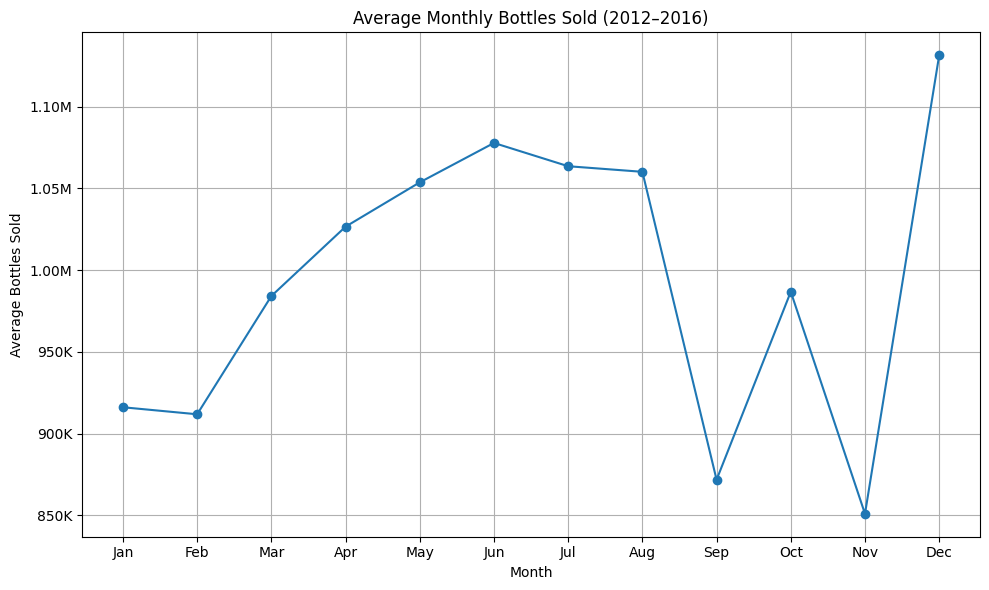

In [25]:
# Filter to 2012–2016
mask = (liquor_df_clean['Date'] >= '2012-01-01') & (liquor_df_clean['Date'] <= '2016-12-31')
filtered = liquor_df_clean[mask].copy()

# Extract month and year
filtered['Year'] = filtered['Date'].dt.year
filtered['Month'] = filtered['Date'].dt.month

# Group by year and month to get total bottles sold
monthly = (
    filtered.groupby(['Year', 'Month'])['Bottles Sold']
    .sum()
    .reset_index()
)

# Average bottles sold per calendar month across years
monthly_avg = (
    monthly.groupby('Month')['Bottles Sold']
    .mean()
    .reset_index()
)

# Format y-axis to use K (thousands)
def format_thousands(x, _):
    if x >= 1_000_000:
        return f'{x/1_000_000:.2f}M'
    return f'{int(x/1_000)}K'

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg['Month'], monthly_avg['Bottles Sold'], marker='o')
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.title('Average Monthly Bottles Sold (2012–2016)')
plt.xlabel('Month')
plt.ylabel('Average Bottles Sold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))
plt.grid(True)
plt.tight_layout()
plt.show()

Most bottle sales in December (holiday season), many sales in summer and little sales during cold months.

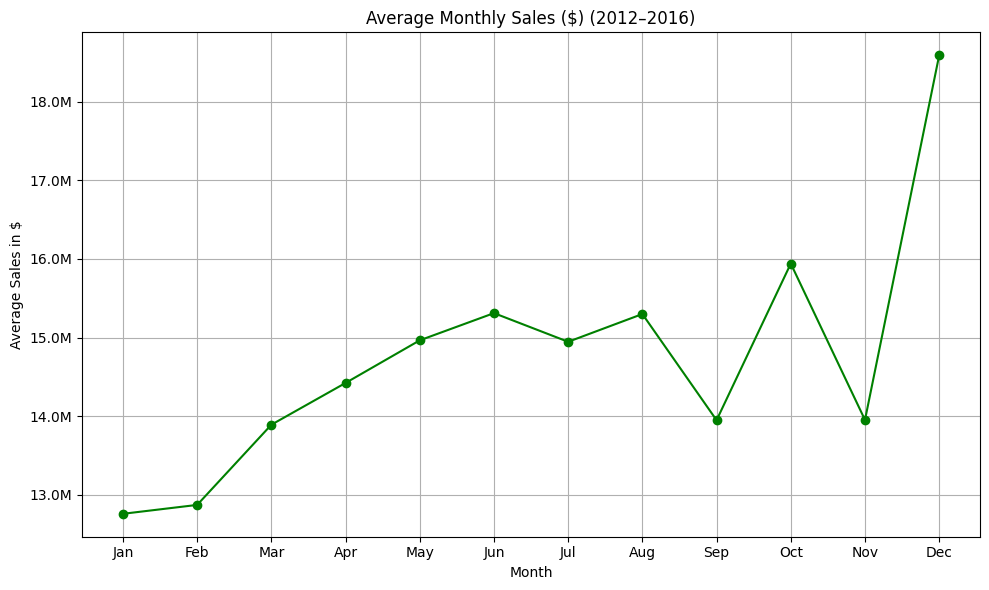

In [26]:
# Filter to 2012–2016
mask = (liquor_df_clean['Date'] >= '2012-01-01') & (liquor_df_clean['Date'] <= '2016-12-31')
filtered = liquor_df_clean[mask].copy()

# Extract month and year
filtered['Year'] = filtered['Date'].dt.year
filtered['Month'] = filtered['Date'].dt.month

# Group by year and month to get total sales in dollars
monthly = (
    filtered.groupby(['Year', 'Month'])['Sale (Dollars)']
    .sum()
    .reset_index()
)

# Average sales per calendar month across years
monthly_sales = (
    monthly.groupby('Month')['Sale (Dollars)']
    .mean()
    .reset_index()
)

# Format y-axis to use K (thousands)
def format_thousands(x, _):
    if x >= 1_000_000:
        return f'{x/1_000_000:}M'
    return f'{int(x/1_000)}K'

plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['Month'], monthly_sales['Sale (Dollars)'], marker='o', color='green')
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.title('Average Monthly Sales ($) (2012–2016)')
plt.xlabel('Month')
plt.ylabel('Average Sales in $')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))
plt.grid(True)
plt.tight_layout()
plt.show()

Most sales ($) in December (holiday season), many sales in summer and October (maybe because of Halloween, Columbus Day), and little sales during cold months and September.

In [28]:
# Aggregate total sales per store with valid coordinates
store_sales = (
    liquor_df_clean
    .dropna(subset=['Latitude', 'Longitude'])
    .groupby(['Store Name', 'Latitude', 'Longitude'])['Sale (Dollars)']
    .sum()
    .reset_index()
)

# Normalize sales for better heatmap visibility (optional, clip extremes)
store_sales['Weight'] = store_sales['Sale (Dollars)'].clip(upper=1_000_000) / 1_000_000

# Create map
sales_map = folium.Map(location=[42.0, -93.0], zoom_start=7)

# Add heatmap layer
HeatMap(
    data=store_sales[['Latitude', 'Longitude', 'Weight']].values,
    radius=10,
    blur=15,
    max_zoom=10
).add_to(sales_map)

# Save as a HTML
sales_map.save('iowa_sales_heatmap.html')

- The heatmap reflects total sales volume by location.
- As expected, the highest sales are concentrated in major cities with more liquor stores.

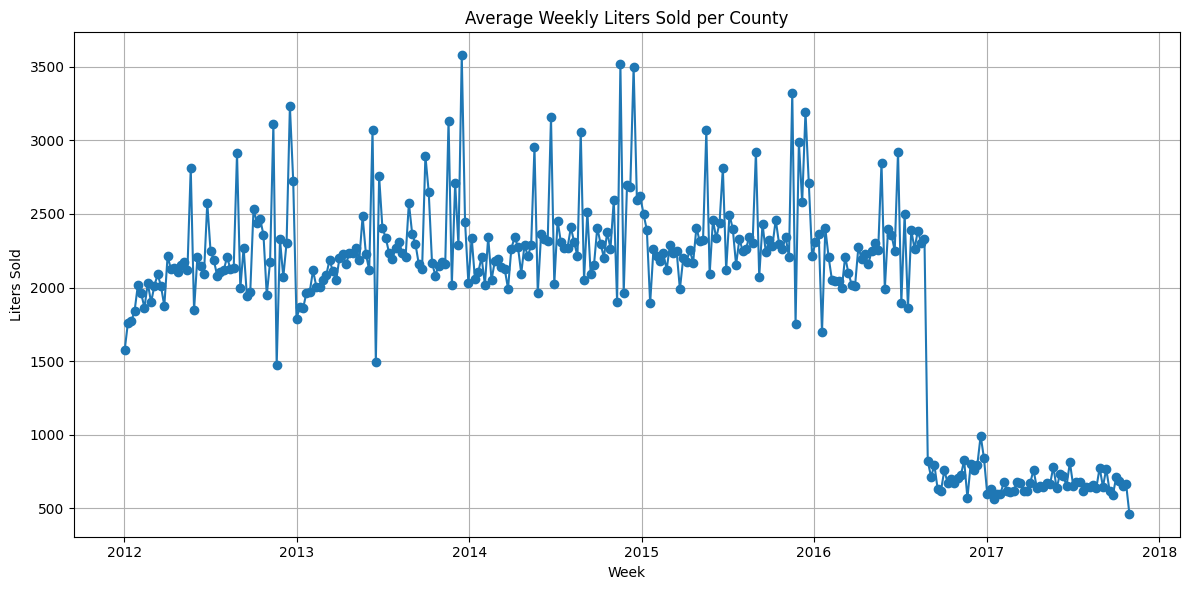

In [29]:
# Copy and convert to weekly period
weekly = liquor_df_clean.copy()
weekly['Week'] = weekly['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Compute liters sold
weekly['Liters Sold'] = (weekly['Bottle Volume (ml)'] * weekly['Bottles Sold']) / 1000

# Group by Week and County, then compute total liters sold per county per week
weekly_county = (
    weekly.groupby(['Week', 'County'])['Liters Sold']
    .sum()
    .reset_index()
)

# Average liters sold per county each week
weekly_avg = (
    weekly_county.groupby('Week')['Liters Sold']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
plt.plot(weekly_avg['Week'], weekly_avg['Liters Sold'], marker='o', linestyle='-')
plt.title('Average Weekly Liters Sold per County')
plt.xlabel('Week')
plt.ylabel('Liters Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

- Average weekly liquor sales per county remained stable from 2012 to mid-2016.
- In the second half of 2016, a sharp and unexplained drop in volume occurs.
- The reason behind this dramatic shift is unclear, but it significantly affects model predictions beyond that point.

---

## Weekly Liquor Sales per County Prediction Using LightGMB

In [81]:
# Create 'Week' column and compute weekly liters sold
weekly_df = liquor_df_clean.copy()
weekly_df['Week'] = weekly_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_df['Liters Sold'] = (weekly_df['Bottle Volume (ml)'] * weekly_df['Bottles Sold']) / 1000

# Aggregate by County and Week
weekly_agg = (
    weekly_df.groupby(['County', 'Week'])
    .agg({
        'Bottle Volume (ml)': 'mean',
        'State Bottle Retail': 'mean',
        'Liters Sold': 'sum',
        'Date': 'count'  # proxy for transaction count
    })
    .rename(columns={'Date': 'Transaction Count'})
    .reset_index()
)

# Feature engineering
weekly_agg['Month'] = weekly_agg['Week'].dt.month
weekly_agg['Year'] = weekly_agg['Week'].dt.year

# Encode only categorical variables
weekly_agg['County'] = LabelEncoder().fit_transform(weekly_agg['County'])

# Define features and target
features = [
    'Bottle Volume (ml)',
    'State Bottle Retail',
    'Month',
    'Year',
    'County',
    'Transaction Count'
]
target = 'Liters Sold'

# Split by full weeks
unique_weeks = weekly_agg['Week'].unique()
train_weeks, valid_weeks = train_test_split(unique_weeks, test_size=0.2, random_state=42)

train_mask = weekly_agg['Week'].isin(train_weeks)
valid_mask = weekly_agg['Week'].isin(valid_weeks)

# Construct X and y
X_train = weekly_agg.loc[train_mask, features].copy()
y_train = weekly_agg.loc[train_mask, target]

X_valid = weekly_agg.loc[valid_mask, features + ['Week']].copy()
y_valid = weekly_agg.loc[valid_mask, target]

# Save 'Week' and 'County' for post-prediction merge
X_valid_weeks = X_valid['Week'].copy()
X_valid_counties = X_valid['County'].copy()

# Drop 'Week' before modeling
X_valid = X_valid.drop(columns=['Week'])

In [82]:
# Prepare LightGBM datasets
train_set = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=['Month', 'County']
)
valid_set = lgb.Dataset(
    X_valid, label=y_valid,
    categorical_feature=['Month', 'County']
)

# Train the model
model = lgb.train(
    {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'n_jobs': -1
    },
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=10000,
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

# Predict and evaluate
y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f'RMSE: {rmse:,.2f}')
print(f'MAE: {mae:,.2f}')
print(f'R²: {r2:.4f}')
print(f'Best iteration: {model.best_iteration}')


RMSE: 517.95
MAE: 177.89
R²: 0.9865
Best iteration: 68


- **MAE (177.9 liters):** On average, predictions differ from actual sales by ~178 liters per county-week.
- **R² (0.9865):** The model explains 98.65% of the variation in weekly liquor sales, indicating excellent accuracy.

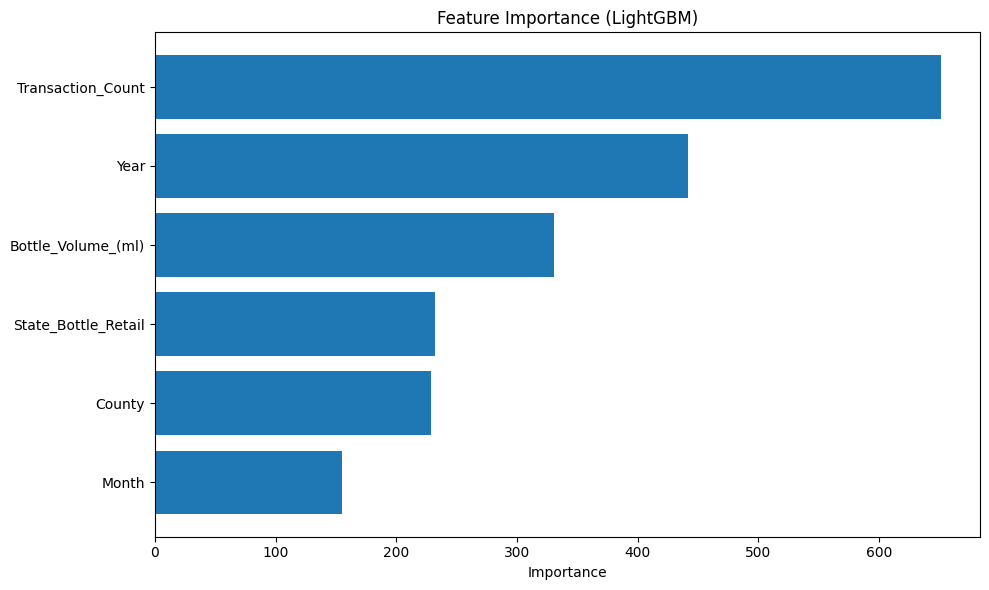

In [49]:
# Get feature names and importances
importance = model.feature_importance()
features = model.feature_name()

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Transaction Count appears to be the most important variable, followed buy Year and Bottle Volume (ml), other features don't fall behind much and also appear relatively important.

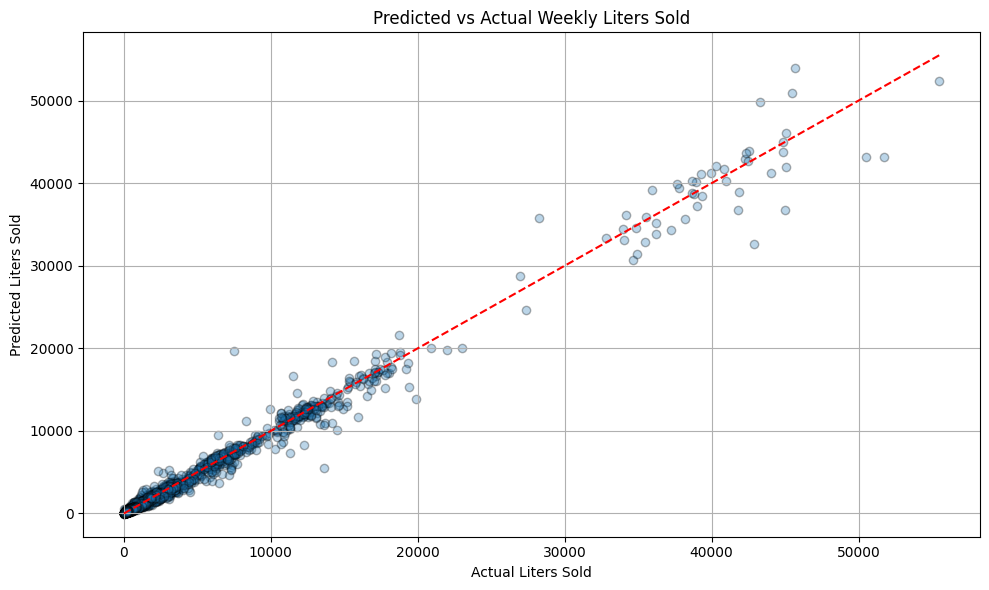

Number of validation points (dots in scatter plot): 5818


In [50]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.title('Predicted vs Actual Weekly Liters Sold')
plt.xlabel('Actual Liters Sold')
plt.ylabel('Predicted Liters Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of validation points (dots in scatter plot): {len(y_valid)}")

The model’s predictions were highly accurate, with no consistent trend of over- or under-prediction across the range except slightly lower accuracy for higher values (which are also a bit scarce - model was not properly trained on them). Overall - amazing results.

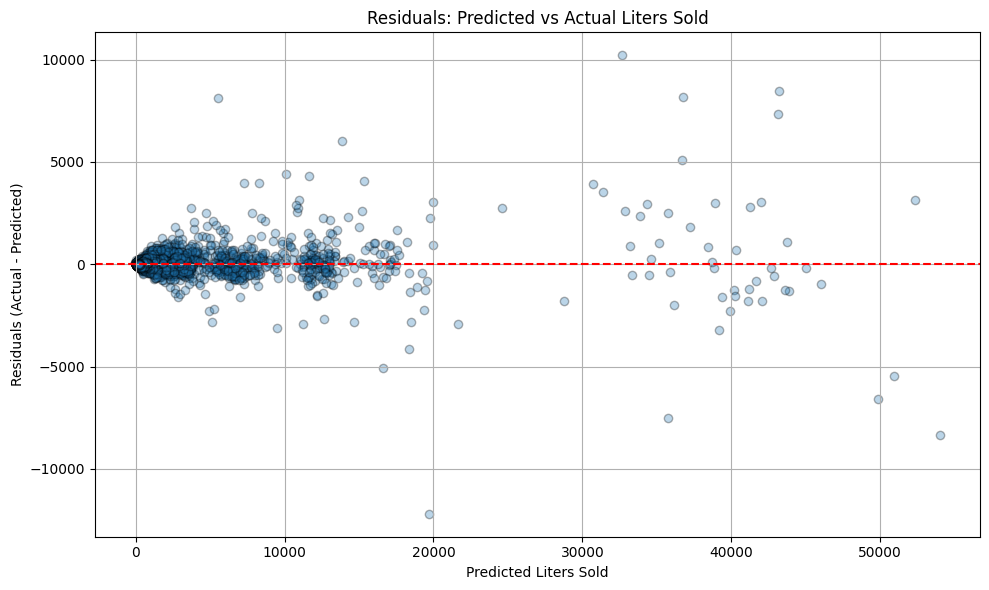

In [ ]:
# Calculate residuals
residuals = y_valid - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals: Predicted vs Actual Liters Sold')
plt.xlabel('Predicted Liters Sold')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()

Residuals are centered around zero, though errors are slightly larger for higher sales volumes which is a common pattern in regression tasks.

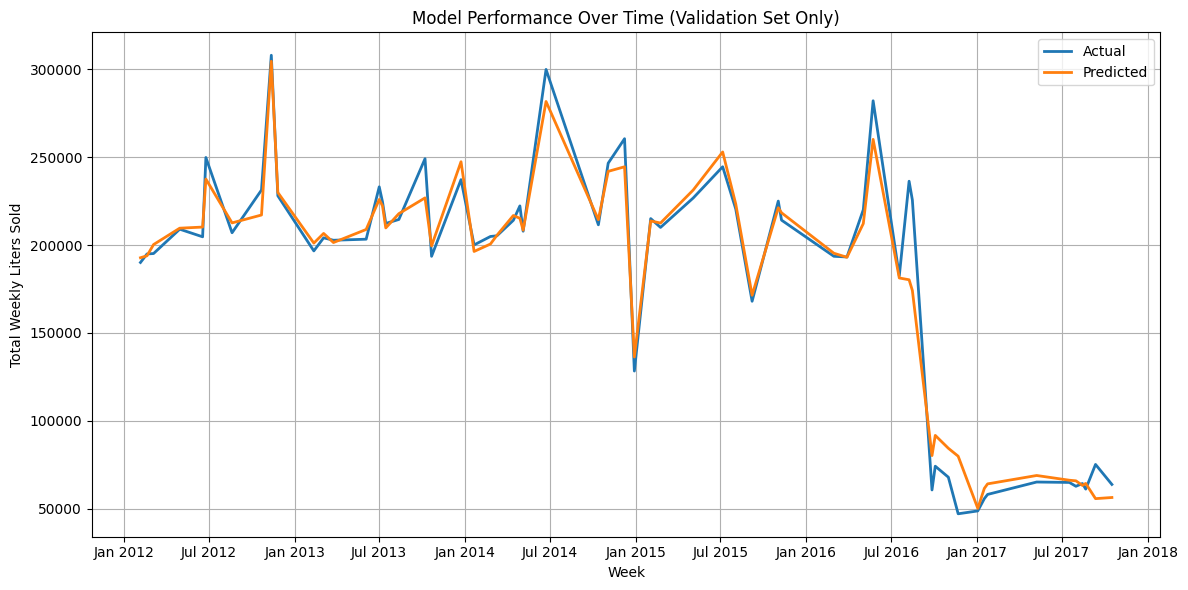

In [ ]:
# Reconstruct validation results
valid_results = X_valid.copy()
valid_results['Actual'] = y_valid.values
valid_results['Predicted'] = y_pred
valid_results['Week'] = X_valid_weeks.values  # Use saved week info

# Group by Week and sum across counties
weekly_perf = (
    valid_results.groupby('Week')[['Actual', 'Predicted']]
    .sum()
    .reset_index()
    .sort_values('Week')
)

# Plot actual vs predicted liters sold over time
plt.figure(figsize=(12, 6))
plt.plot(weekly_perf['Week'], weekly_perf['Actual'], label='Actual', linewidth=2)
plt.plot(weekly_perf['Week'], weekly_perf['Predicted'], label='Predicted', linewidth=2)
plt.title('Model Performance Over Time (Validation Set Only)')
plt.xlabel('Week')
plt.ylabel('Total Weekly Liters Sold')
plt.legend()
plt.grid(True)

# Set only Jan and Jul ticks on x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7), bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks()

plt.tight_layout()
plt.show()

- The model remains highly accurate over time, even capturing the sharp decline in liquor demand after mid-2016 (based on county-averaged weekly sales).
- This strong performance is likely due to the randomized week-based validation split, which allowed the model to learn from all time periods – including the drop.

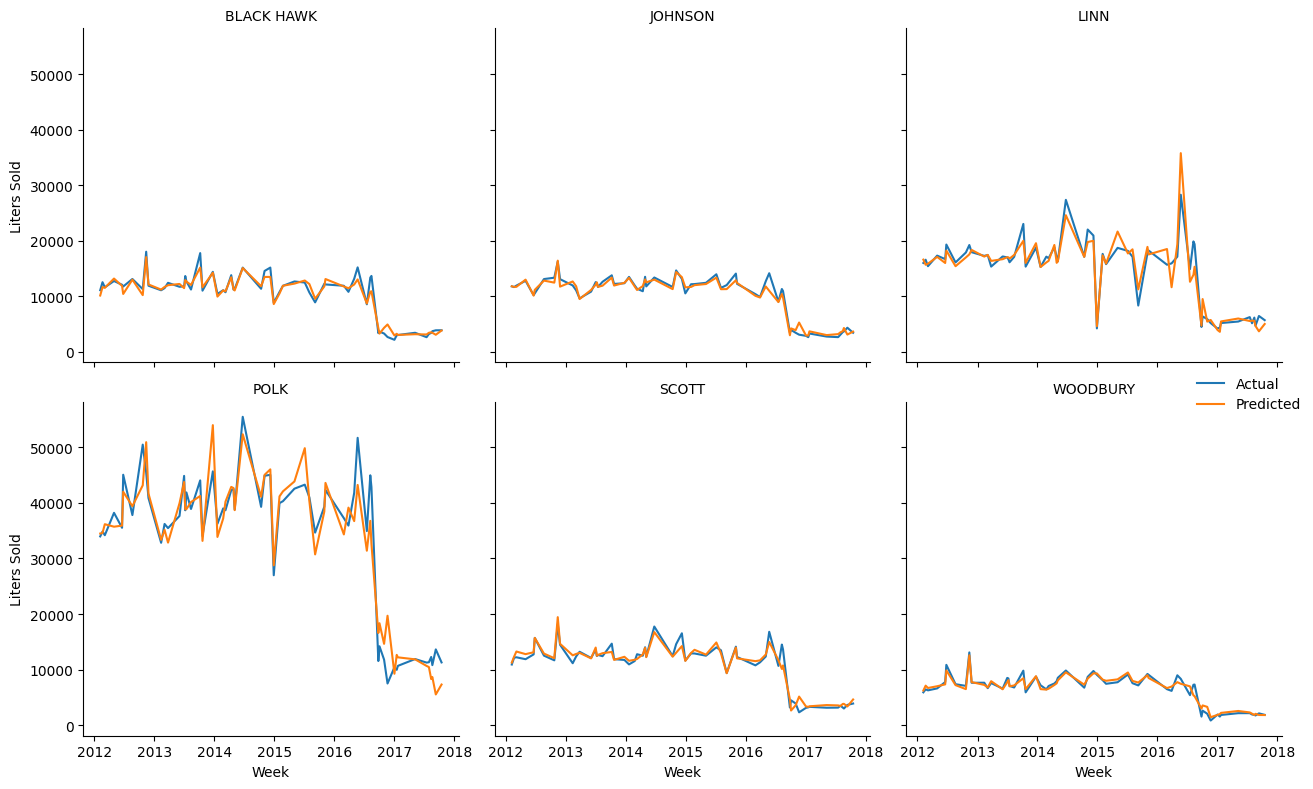

In [ ]:
# Refit encoder and decode county names
county_encoder = LabelEncoder()
county_encoder.fit(liquor_df_clean['County'])
decoded_counties = county_encoder.inverse_transform(X_valid_counties.values)

# Prepare full validation results with week and decoded county info
valid_results = X_valid.copy()
valid_results['Actual'] = y_valid.values
valid_results['Predicted'] = y_pred
valid_results['Week'] = X_valid_weeks.values
valid_results['County'] = decoded_counties  # Use decoded names

# Melt for plotting
melted = pd.melt(
    valid_results,
    id_vars=['Week', 'County'],
    value_vars=['Actual', 'Predicted'],
    var_name='Type',
    value_name='Liters Sold'
)

# Limit to top 6 counties by total volume
top_counties = (
    valid_results.groupby('County')['Actual'].sum()
    .sort_values(ascending=False)
    .head(6).index
)
subset = melted[melted['County'].isin(top_counties)]

# Faceted line plot
g = sns.FacetGrid(subset, col='County', col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x='Week', y='Liters Sold', hue='Type')
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.tight_layout()
plt.show()

Accuracy of predictions for a samll subset of decoded counties also looks very good.

In [61]:
# Confirm unique (County, Week) pairs
dupes = valid_results.duplicated(subset=['County', 'Week'])
print(f"Duplicate (County, Week) pairs: {dupes.sum()}")  # Should be 0

# Check number of unique weeks
unique_weeks = valid_results['Week'].nunique()
print(f"Number of unique weeks in validation set: {unique_weeks}")

# Sum total weekly actuals and predicted values
weekly_sum_check = (
    valid_results.groupby('Week')[['Actual', 'Predicted']]
    .sum()
    .reset_index()
)

# Print a few rows to inspect
print(weekly_sum_check.head())

# Total liters sold (should be reasonably high but not outrageous)
print("\nSanity check: total actual and predicted liters sold in validation set:")
print(f"Total actual:   {weekly_sum_check['Actual'].sum():,.0f} L")
print(f"Total predicted: {weekly_sum_check['Predicted'].sum():,.0f} L")


Duplicate (County, Week) pairs: 0
Number of unique weeks in validation set: 61
        Week         Actual      Predicted
0 2012-02-06 190,074.800000 192,763.385096
1 2012-02-20 194,916.525000 193,880.587786
2 2012-03-05 195,160.450000 200,257.619642
3 2012-04-30 209,002.625000 209,577.081004
4 2012-06-18 204,673.175000 210,209.299840

Sanity check: total actual and predicted liters sold in validation set:
Total actual:   11,117,287 L
Total predicted: 11,031,340 L


- Duplicate (County, Week) pairs: 0: Each (County, Week) entry is unique, so no duplication is inflating totals.

- Number of unique weeks: 61: There are ~20% of ~300 total weeks (from 2012–2017) in validation set.

- Actual weekly liters sold: ~190k–210k: This is expected across all counties in Iowa per week, not per county. Iowa selling ~200k liters/week statewide is realistic.

- Total liters sold (validation):

    - Actual: ~11.1M liters

    - Predicted: ~11.0M liters
    
These are close, showing the model is well-calibrated.

---

## Weekly Liquor Sales per County (Split by Time, but Dropping the Period after mid-2016)

In [ ]:
# Filter data to first half of 2016
weekly_df = liquor_df_clean[liquor_df_clean['Date'] < '2016-07-01'].copy()

# Create 'Week' column and compute weekly liters sold
weekly_df['Week'] = weekly_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_df['Liters Sold'] = (weekly_df['Bottle Volume (ml)'] * weekly_df['Bottles Sold']) / 1000

# Aggregate by County and Week
weekly_agg = (
    weekly_df.groupby(['County', 'Week'])
    .agg({
        'Bottle Volume (ml)': 'mean',
        'State Bottle Retail': 'mean',
        'Liters Sold': 'sum',
        'Date': 'count'  # proxy for transaction count
    })
    .rename(columns={'Date': 'Transaction Count'})
    .reset_index()
)

# Feature engineering
weekly_agg['Month'] = weekly_agg['Week'].dt.month
weekly_agg['Year'] = weekly_agg['Week'].dt.year

# Encode categorical variables
weekly_agg['County'] = LabelEncoder().fit_transform(weekly_agg['County'])

# Define features and target
features = [
    'Bottle Volume (ml)',
    'State Bottle Retail',
    'Month',
    'Year',
    'County',
    'Transaction Count'
]
target = 'Liters Sold'

# Time-ordered split by unique weeks
unique_weeks = sorted(weekly_agg['Week'].unique())
split_index = int(0.8 * len(unique_weeks))
train_weeks = unique_weeks[:split_index]
valid_weeks = unique_weeks[split_index:]

# Create train/val masks
train_mask = weekly_agg['Week'].isin(train_weeks)
valid_mask = weekly_agg['Week'].isin(valid_weeks)

# Prepare X and y
X_train = weekly_agg.loc[train_mask, features].copy()
y_train = weekly_agg.loc[train_mask, target]

X_valid = weekly_agg.loc[valid_mask, features + ['Week']].copy()
y_valid = weekly_agg.loc[valid_mask, target]

# Save for merging after prediction
X_valid_weeks = X_valid['Week'].copy()
X_valid_counties = X_valid['County'].copy()

# Drop 'Week' before training
X_valid = X_valid.drop(columns=['Week'])

In [ ]:
# Prepare LightGBM datasets
train_set = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=['Month', 'County']
)
valid_set = lgb.Dataset(
    X_valid, label=y_valid,
    categorical_feature=['Month', 'County']
)

# Train model
model = lgb.train(
    {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'n_jobs': -1
    },
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=10000,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Evaluate
y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f'RMSE: {rmse:,.2f}')
print(f'MAE: {mae:,.2f}')
print(f'R²: {r2:.4f}')
print(f'Best iteration: {model.best_iteration}')

RMSE: 443.62
MAE: 161.25
R²: 0.9924
Best iteration: 235


Slightly better performance than the initial model.

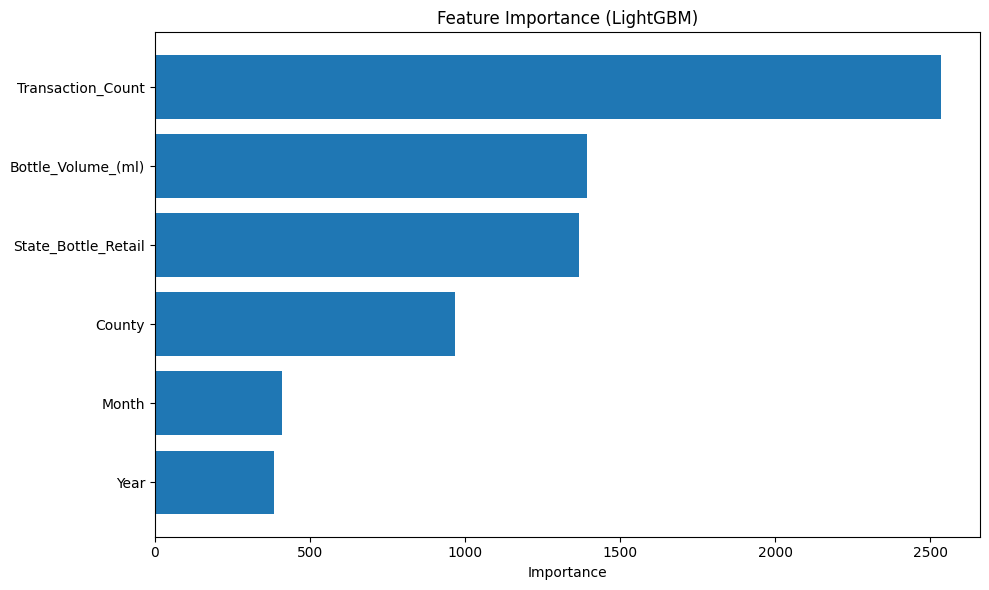

In [69]:
# Get feature names and importances
importance = model.feature_importance()
features = model.feature_name()

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Similar feature importance, but much bigger magnitude. Year drops to last place from 2nd place in the initial model.

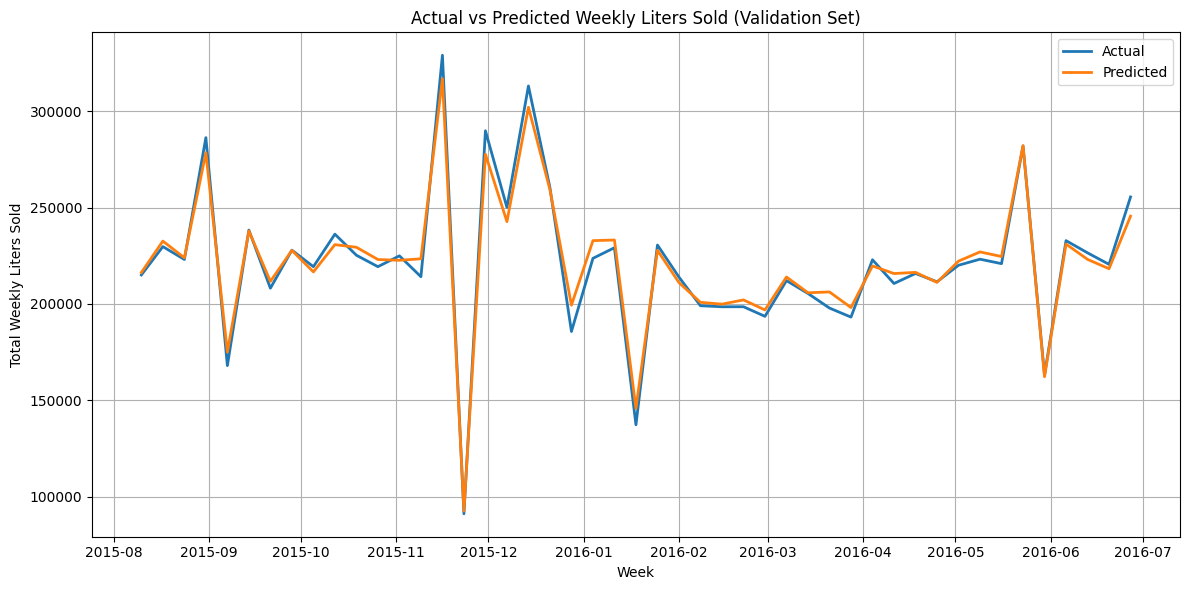

In [ ]:
# Reconstruct validation results
valid_results = X_valid.copy()
valid_results['Actual'] = y_valid.values
valid_results['Predicted'] = y_pred
valid_results['Week'] = X_valid_weeks.values

# Group by Week and sum across counties
weekly_perf = (
    valid_results.groupby('Week')[['Actual', 'Predicted']]
    .sum()
    .reset_index()
    .sort_values('Week')
)

plt.figure(figsize=(12, 6))
plt.plot(weekly_perf['Week'], weekly_perf['Actual'], label='Actual', linewidth=2)
plt.plot(weekly_perf['Week'], weekly_perf['Predicted'], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Weekly Liters Sold (Validation Set)')
plt.xlabel('Week')
plt.ylabel('Total Weekly Liters Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- This version of the model uses a time-based split, training on data up to August 2015 and validating on the period from August 2015 to July 2016.
- Data beyond July 2016 is excluded to avoid the known structural drop in sales, which would otherwise cause the model to systematically overpredict.

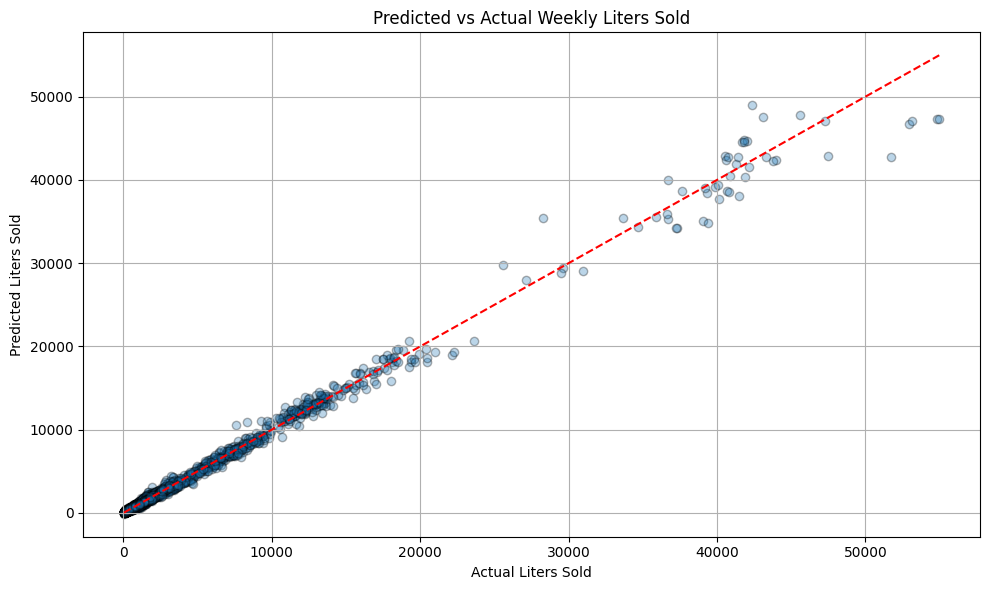

Number of validation points (dots in scatter plot): 4458


In [67]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.title('Predicted vs Actual Weekly Liters Sold')
plt.xlabel('Actual Liters Sold')
plt.ylabel('Predicted Liters Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of validation points (dots in scatter plot): {len(y_valid)}")

Accurate predictions (slightly lower accuracy for bigger values).

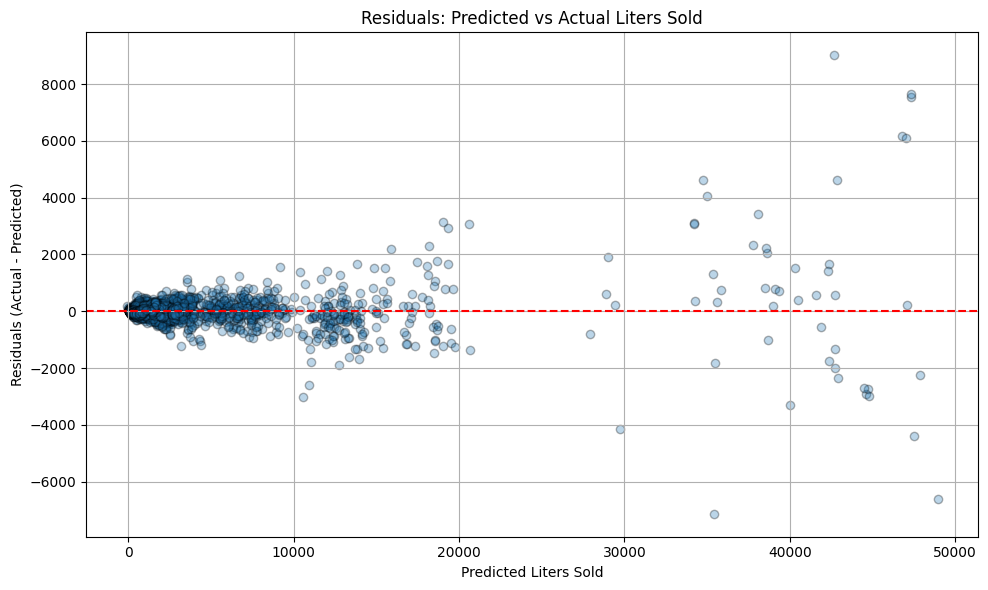

In [ ]:
# Calculate residuals
residuals = y_valid - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals: Predicted vs Actual Liters Sold')
plt.xlabel('Predicted Liters Sold')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()

Residuals are centered around zero, though errors are slightly larger for higher sales volumes which is a common pattern in regression tasks.